In [18]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Landsat-8 WOFS Product Creation**

### Config

Import required DC utils

In [19]:
import datacube
# DC utilities
from utils_dcal.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_netcdf

Define aoi via wkt polygon (could be subbed or shapefile)

In [20]:
aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [21]:
dc = datacube.Datacube(app="na")

In [22]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ]
          ]
        ]
      }
    }
  ]
}

In [23]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-18.27, -18.25) 
Lon: (178.12, 178.15)


### Load Data

Generic query specs

In [24]:
query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2017,1,1), datetime(2017,2,1)),
                resolution = (30,30))

Dataset-specifics

In [25]:
scenes = dc.load(product="ls8_usgs_sr_scene",
               group_by='solar_day',
               measurements = ["green","red","blue","nir","swir1","swir2","coastal_aerosol","pixel_qa"],
               **query)

We've been testing removal of no-data value to nan. This doesn't seem to work though as outputs from wofs over nan areas is 0, which skews the total no. observations.

In [26]:
scenes = scenes.where(scenes != -9999.) 

Check loaded

In [27]:
scenes

<xarray.Dataset>
Dimensions:          (time: 4, x: 107, y: 75)
Coordinates:
  * time             (time) datetime64[ns] 2017-01-07T22:06:49.107044 ... 2017-01-30T22:12:51.641971
  * y                (y) float64 7.98e+06 7.98e+06 ... 7.982e+06 7.982e+06
  * x                (x) float64 6.184e+05 6.184e+05 ... 6.216e+05 6.216e+05
Data variables:
    green            (time, y, x) float64 550.0 554.0 556.0 ... nan nan nan
    red              (time, y, x) float64 386.0 403.0 405.0 ... nan nan nan
    blue             (time, y, x) float64 339.0 340.0 343.0 ... nan nan nan
    nir              (time, y, x) float64 192.0 199.0 207.0 ... nan nan nan
    swir1            (time, y, x) float64 197.0 201.0 205.0 ... nan nan nan
    swir2            (time, y, x) float64 165.0 170.0 170.0 ... nan nan nan
    coastal_aerosol  (time, y, x) float64 228.0 230.0 241.0 ... nan nan nan
    pixel_qa         (time, y, x) float64 324.0 324.0 324.0 ... 1.0 1.0 1.0
Attributes:
    crs:      EPSG:32760

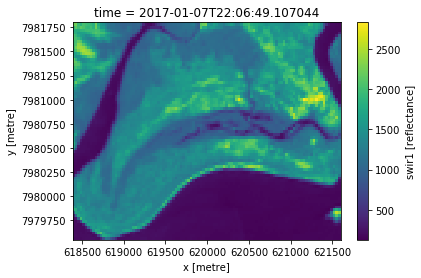

In [28]:
scenes.isel(time = 0).swir1.plot();

Create + apply 'cleansky' mask

In [29]:
clearsky_masks = landsat_qa_clean_mask(scenes, 'LANDSAT_8')
clearsky_scenes = scenes.where(clearsky_masks)

Apply wofs classification

In [30]:
water_classes = wofs_classify(clearsky_scenes, no_data = np.nan , x_coord='x', y_coord = "y")

Visualise wofs summary product

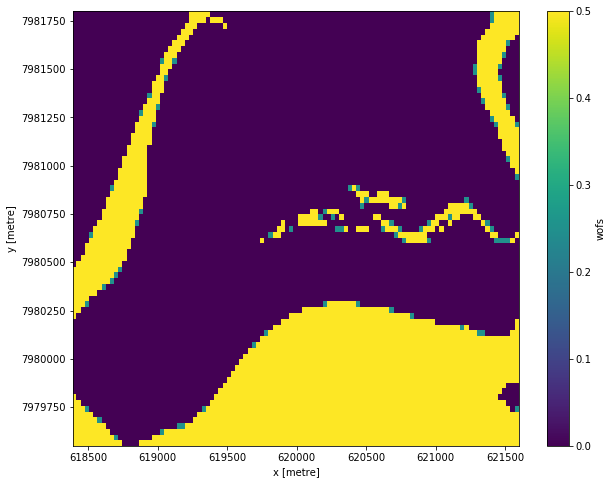

In [31]:
plt.figure(figsize = (10,8))
water_classes.wofs.mean(dim = 'time').plot();

### Export to file within shared storage

Define output path

In [32]:
# Ensure the output directory exists before writing to it.
!mkdir -p /home/shared/geo_demos/wofs_testers
output_file_name  =  "/home/shared/geo_demos/wofs_testers/l8_wofs_product.nc"

Correct attributes and add to wofs xarray (for some reason we have 'dc_partual_load' as true...)

In [33]:
scenes.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

In [34]:
# at = scenes.attrs
# del at['dc_partial_load']
# at

In [35]:
dataset_to_output =  water_classes.assign_attrs(scenes.attrs)

In [36]:
dataset_to_output.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

Export

In [37]:
export_xarray_to_netcdf(dataset_to_output, output_file_name)